EJERCICIO DE OPTIMIZACIÓN DE LAS GANANCIAS DEL CONTROLADOR PID.

Sobre el controlador PID desarrollado en la práctica anterior, desarrollar un algoritmo genético que sea capaz de optimizar el valor de las ganancias Kp, Ki y Kd, a fin de obener el controlador con mejor rendimiento posible.
Para ello, se debe:
- Definir el tamaño del cromosoma =3 = (Kp,Ki,Kd)
- Definir la función de fitness = self.w = (25., .6, 200., 15.) # weight of ts, d, overshot, ess . Es decir ts*25.0 + 0.6*d + overshoot*200.0+ ess*0.15
- La selección se realizará por torneo. Definir el valor de T=8
- Especificar el número de itaraciones para ajustar el controlador=200
- Definir el tamaño de la población=100


MODELO, CONTROLADOR PID E ÍNDICES DE RENDIMIENTO

In [5]:
class DC_motor_sim:
    def __init__(self):
        self.R = 1.11  # Ohm
        self.L = 0.0002  # H
        self.J = 6.77E-6  # Kgm²
        self.fv = 1.66E-5  # Nm/(Rad/s)
        self.K = 0.0364  # Nm/A or V/(Rad/s)
        self.ea = 0.0
        self.w = [0.0, 0.0]  # tk angular speed
        self.i = [0.0, 0.0]  # tk current

    def init(self):
        self.R = 1.11
        self.L = 0.0002
        self.J = 6.77E-6
        self.fv = 1.66E-5
        self.K = 0.0364
        self.ea = 0.0
        self.w = [0.0, 0.0]
        self.i = [0.0, 0.0]

    def Set_ea(self, new_ea):
        self.ea = new_ea
        # Saturation effect due to battery limits
        if self.ea > 24.0:
            self.ea = 24.0
        if self.ea < -24.0:
            self.ea = -24.


    def Give_me_speed(self): 
        return self.w[0]

    def Exec_cycle(self):
        # Motor behavior considering T = 0.0001s
        self.w[0] = self.w[1]
        self.i[0] = self.i[1]
        self.w[1] = 0.999755 * self.w[0] + 14.769238 * self.K * self.i[0]
        self.i[1] = 0.574072 * self.i[0] + 0.383719 * (self.ea - self.K * self.w[1])
        
class Controller:
    def __init__(self):
        self.Kp = 0.0
        self.Ki = 0.0
        self.Kd = 0.0
        self.Angular_speed_reference = 0.0
        self.Controller_T = 0.001
        self.motor_sim = DC_motor_sim()
        self.motor_speed_anterior = 0
        self.I_anterior = 0
        self.D_anterior = 0

    def Init(self, new_Kp, new_Ki, new_Kd):
        self.Kp = new_Kp
        self.Ki = new_Ki
        self.Kd = new_Kd

        # Inicializar el motor
        self.motor_sim.init()
        

    def Set_reference(self, Angular_speed):
        self.Angular_speed_reference = Angular_speed

    def Exec_controller_cycle(self):
        # Compute control parameters
        motor_speed = DC_motor_sim.Give_me_speed(self.motor_sim)
        
        P = 0 # Poner las ecuaciones definidas en el ejercicio anterior <----------------------
        I = 0 # Poner las ecuaciones definidas en el ejercicio anterior
        D = 0 # Poner las ecuaciones definidas en el ejercicio anterior
        
        # Prepare last error for next cycle       
        self.motor_speed_anterior = motor_speed
        
        # Compute controller output
        new_motor_voltage = P+I+D
        DC_motor_sim.Set_ea(self.motor_sim, new_motor_voltage)
        DC_motor_sim.Exec_cycle(self.motor_sim)

        return motor_speed, new_motor_voltage
    
    
import numpy as np
import statistics as stat

class Performance:    
    def __init__(self):
        self.Overshoot = 0.0
        self.d = 0.0
        self.Ess = 0.0
        self.Ts = 0.0
        self.v = []
        self.VR = 0.0

    def Init(self, velocidades, Velocidad_de_referencia):
        self.Overshoot = 0.0
        self.d = 0.0
        self.Ess = 0.0
        self.Ts = 0.0
        self.v = velocidades
        self.VR = Velocidad_de_referencia
        
    def Calcula_indexes(self):
   
        #escribir aquí el código para el cálculo de los índices de rendimiento

        return self.Overshoot, self.d, self.Ess, self.Ts


ALGORITMO GENÉTICO

In [6]:
import random
from operator import itemgetter

#algoritmo genético
class Genetico:

    def __init__(self):
        #Fitness
        self.Fitness = 0;
        self.w = (25., .6, 200., 15.) # weight of ts, d, overshot, ess 
        
    def llamada_control(self, Gen_Kp, Gen_Ki, Gen_Kd):   
        # Crear una instancia del controlador
        controller = Controller()
        Kp=Gen_Kp
        Ki=Gen_Ki
        Kd=Gen_Kd
        velocidad=[]
        ut=[]
        coordenadax=[]
        Velocidad_de_referencia = 50.0
        overshoot = 0.0
        d=0.0
        Ess=0.0
        Ts = 0.0
        
        # Inicializar el controlador con los valores de ganancia
        controller.Init(Kp, Ki, Kd)
        
        # Establecer la velocidad de referencia
        controller.Set_reference(Velocidad_de_referencia)

        # Ejecutar 320 ciclos del controlador
        for ite in range(320):
            x,y = controller.Exec_controller_cycle()
            velocidad.append(x)
            
           # self.ut.append(y)
           # self.coordenadax.append(ite)            
           
        #Cálculo de los índices de rendimiento
        P = Performance() 
        P.Init(velocidad, Velocidad_de_referencia)
        overshoot, d, Ess, Ts = P.Calcula_indexes()
        
        Fitness = 0 # Aquí se debe implementar la función de fitness correspondiente.<------------------------------
        # MIRAR INIT SELF.W
        # LEER EL ARTICULO PARA MEJORAR
        return Fitness

    
    # Función de evaluación (fitness)
    def evaluate(self, chromosome):
        # Aquí debes implementar la evaluación del cromosoma y retornar un valor de fitness
        fitness = self.llamada_control(chromosome[0], chromosome[1], chromosome[2])
        return fitness

    # Generar un cromosoma aleatorio
    def generate_random_chromosome(self, length):  
        chromosome = []
        for _ in range(length):
            gene = random.uniform(0.0, 10.0)  # Generar número aleatorio en el rango [0.0, 10.0]
            chromosome.append(gene)            
        return chromosome

    # Cruzar dos cromosomas
    def crossover(self, chromosome1, chromosome2, crossover_rate):
        new_chromosome=chromosome1
        if random.random() < crossover_rate:
            crossover_point = random.randint(1, len(chromosome1) - 1)
            new_chromosome = chromosome1[:crossover_point] + chromosome2[crossover_point:]
        return new_chromosome
        
    # Mutar un cromosoma
    def mutate(self, chromosome, mutation_rate):
        mutated_chromosome = []
        for gene in chromosome:
            if random.random() < mutation_rate:
                mutated_gene = random.uniform(0.0, 10.0)  # Generar número aleatorio en el rango [0.0, 5.0]
            else:
                mutated_gene = gene
            mutated_chromosome.append(mutated_gene)
        return mutated_chromosome

    #selección por torneo
    def selection_tournament(self, population_size, evaluated_population, T):
            parents = []            
            while len(parents) < population_size:
                candidates=[]
                for ite in range(T):
                    candidates.append(random.choice(evaluated_population))                            
                parents.append(min(candidates, key=itemgetter(1))[0])
            return parents
    
    # Algoritmo genético
    def genetic_algorithm(self, population_size, chromosome_length, generations, mutation_rate, crossover_rate):
        population = []
        for _ in range(population_size):
            chromosome = self.generate_random_chromosome(chromosome_length)
            population.append(chromosome)
       
        for generation in range(generations):            
            # Evaluación de la población
            evaluated_population = [(chromosome, self.evaluate(chromosome)) for chromosome in population]

            # Selección de padres mediante torneo de longitud T
            parents = []
            T=8 # Se seleccionan 8 cromosomas de manera aleatoria pra el torneo. Nos quedaremos con el de menor función de fitness
            parents = self.selection_tournament(population_size, evaluated_population, T)

            # Cruzamiento y mutación para generar descendencia
            offspring = []
            for i in range(0, population_size, 2):
                parent1 = parents[i]
                parent2 = parents[i + 1]
                child1 = self.crossover(parent1, parent2, crossover_rate)
                child2 = self.crossover(parent2, parent1, crossover_rate)
                mutated_child1 = self.mutate(child1, mutation_rate)
                mutated_child2 = self.mutate(child2, mutation_rate)
                offspring.extend([mutated_child1, mutated_child2])

            # Reemplazar la población anterior con la descendencia
            population = offspring

        # Devolver el mejor cromosoma de la última generación
        best_chromosome = min(evaluated_population, key=lambda x: x[1])#[0]
        return best_chromosome



Dibujar el resultado de la optimización mediante el algoritmo genético

In [8]:
from matplotlib import pyplot as plt

class dibujacontrol:
    

    def dibujar (self, Kp, Ki, Kd):
        
        fig, ax = plt.subplots()
        fig, ax2 = plt.subplots()
        P = Performance()  
        
        # Crear una instancia del controlador
        controller = Controller()

        
        velocidad=[]
        ut=[]
        coordenadax=[]

        Velocidad_de_referencia = 50.0
        
        # Inicializar el controlador con los valores de ganancia
        controller.Init(Kp, Ki, Kd)

        # Establecer la velocidad de referencia
        controller.Set_reference(Velocidad_de_referencia)

        # Ejecutar 320 ciclos del controlador
        for ite in range(320):
            x,y = controller.Exec_controller_cycle()
            velocidad.append(x)
            ut.append(y)
            coordenadax.append(ite)
        ax.plot(coordenadax, velocidad, linewidth=2.0)
        ax.grid(axis='x', color='0.95')
        ax.grid(axis='y', color='0.95')
        ax2.plot(coordenadax, ut, linewidth=2.0)
        ax2.grid(axis='x', color='0.95')
        ax2.grid(axis='y', color='0.95')

        P.Init(velocidad, Velocidad_de_referencia)
        o, d, Ess, Ts = P.Calcula_indexes()
        print("Overshoot: ",o)
        print("d: ",d)
        print("Ess: ",Ess)
        print("Ts:", Ts)

Llamada al algoritmo genético (tarda un poquito, en función de el número de generaciones programadas)

Mejor cromosoma: ([2.263056704442268, 3.080953419982604, 5.455488723426269], 0)


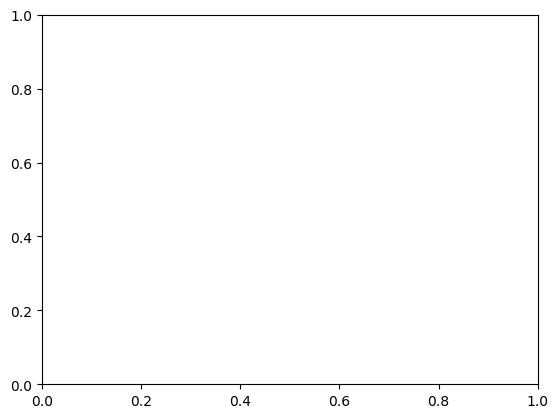

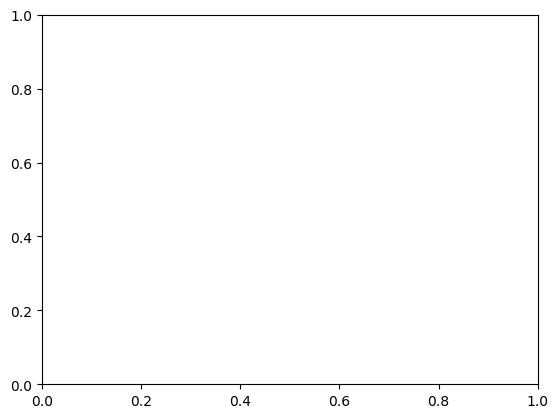

<class 'AttributeError'>: 'Controller' object has no attribute 'Exec_controller_cycleJE'

In [9]:
# Parámetros del algoritmo genético
population_size = 100
chromosome_length = 3
generations = 200
mutation_rate = 0.1
crossover_rate = 0.6

gen = Genetico()
# Ejecutar el algoritmo genético
best_chromosome = gen.genetic_algorithm(population_size, chromosome_length, generations, mutation_rate, crossover_rate)

# Imprimir el resultado
print("Mejor cromosoma:", best_chromosome)
BC = best_chromosome[0]
DC=dibujacontrol()
DC.dibujar(BC[0],BC[1], BC[2])